In [1]:
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
languages = {
    'id': 'nat', 
    'tl': 'nat', 
    'tr': 'nat', 
    'en': 'nat', 
    'de': 'nat',
    'fr': 'nat',
    'eo': 'con',
    'lfn': 'con',
    'ia': 'con',
    'io': 'con',
    'pl': 'nat',
    'vi': 'nat',
    'fi': 'nat',
    'it': 'nat',
    'af': 'nat',
    'nl': 'nat',
    'es': 'nat',
    'oc': 'nat',
    'da': 'nat',
    'sv': 'nat',
    'is': 'nat',
    'hu': 'nat',
    }

torch_rnn_df = pd.read_csv('./results/torch_rnn_results.csv', index_col=0)
dfs = []
for lang in languages:
    temp = torch_rnn_df.loc[(torch_rnn_df['epoch'] == 20) & (torch_rnn_df['corpus'] == lang)]
    temp = temp[temp['step'] == temp['step'].max()]
    dfs.append(temp)
    
ref = pd.concat(dfs)
df = ref[['corpus', 'val_perplexity']]
df.insert(1, 'type', ref['corpus'].apply(lambda x: languages.get(x)))

prelim_df = pd.read_csv('./results/prelim.csv', sep='\t')

data = pd.merge(df, prelim_df)
data.to_csv('./results/clf_df.csv', index=False)
data

,corpus,type,val_perplexity,TTR,MATTR,Char Entr,Word Entr
0,id,nat,3.595690,5.804406,0.700090,4.070997,11.148131
1,tl,nat,3.544414,7.498319,0.609710,3.894602,9.976462
2,tr,nat,4.257474,13.993292,0.827652,4.386971,13.166179
3,en,nat,4.138779,6.025770,0.697744,4.166890,10.690033
4,de,nat,4.002635,12.010972,0.769293,4.230064,11.598005
5,fr,nat,3.625466,7.304848,0.721023,4.177654,10.715771
6,eo,con,3.909751,10.589734,0.692378,4.164256,10.920602
7,lfn,con,4.059735,5.083459,0.600948,3.912139,9.320495
8,ia,con,3.762086,6.795857,0.596837,4.030916,9.935303
9,io,con,1.153088,3.677265,0.566818,4.083562,8.296066


In [3]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'nat':1, 'con':0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
}

clf = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


{'criterion': 'gini', 'max_depth': 4, 'max_features': 0.2, 'splitter': 'best'}


In [5]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=2, max_features=0.4, splitter='best')
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_features=0.4)

In [6]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8333333333333334


[Text(0.4, 0.8333333333333334, 'x[2] <= 0.623\ngini = 0.305\nsamples = 16\nvalue = [3, 13]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.6, 0.5, 'x[2] <= 0.695\ngini = 0.133\nsamples = 14\nvalue = [1, 13]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]')]

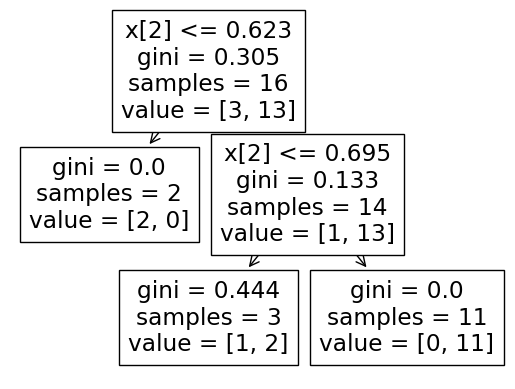

In [7]:
tree.plot_tree(clf)